<h1 align="center">Letter Recognition - UCI</h1>

In [1]:
import pandas as pd
import numpy as np
%pylab inline
pylab.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# Getting the Data

This is a dataset of 20 image features for uppercase English characters.

https://archive.ics.uci.edu/ml/datasets/Letter+Recognition

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data'
letter_df = pd.read_csv(url, header=None)

In [4]:
letter_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


Next we attach the column names.

In [6]:
s = """ 1.	lettr	capital letter	(26 values from A to Z)
	 2.	x-box	horizontal position of box	(integer)
	 3.	y-box	vertical position of box	(integer)
	 4.	width	width of box			(integer)
	 5.	high 	height of box			(integer)
	 6.	onpix	total # on pixels		(integer)
	 7.	x-bar	mean x of on pixels in box	(integer)
	 8.	y-bar	mean y of on pixels in box	(integer)
	 9.	x2bar	mean x variance			(integer)
	10.	y2bar	mean y variance			(integer)
	11.	xybar	mean x y correlation		(integer)
	12.	x2ybr	mean of x * x * y		(integer)
	13.	xy2br	mean of x * y * y		(integer)
	14.	x-ege	mean edge count left to right	(integer)
	15.	xegvy	correlation of x-ege with y	(integer)
	16.	y-ege	mean edge count bottom to top	(integer)
	17.	yegvx	correlation of y-ege with x	(integer)"""

lines = [l.strip() for l in s.split('\n')]
feature_names = [l.split()[1] for l in lines]
feature_names = [f.replace('-', '_') for f in feature_names]

In [7]:
letter_df.columns = feature_names

In [8]:
letter_df.head()

,lettr,x_box,y_box,width,high,onpix,x_bar,y_bar,x2bar,y2bar,xybar,x2ybr,xy2br,x_ege,xegvy,y_ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


# Check for Class Imbalance

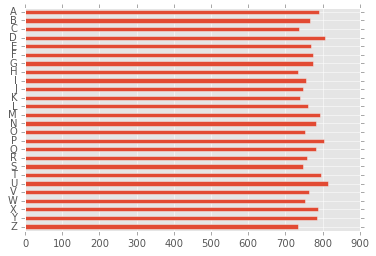

In [11]:
letter_counts = letter_df['lettr'].value_counts()
letter_counts.sort_index(ascending=False).plot(kind='barh')

All the classes are represented in a fairly balanced manner, so looks like in this instance we don't have to address class imbalance.

# Feature Correlations

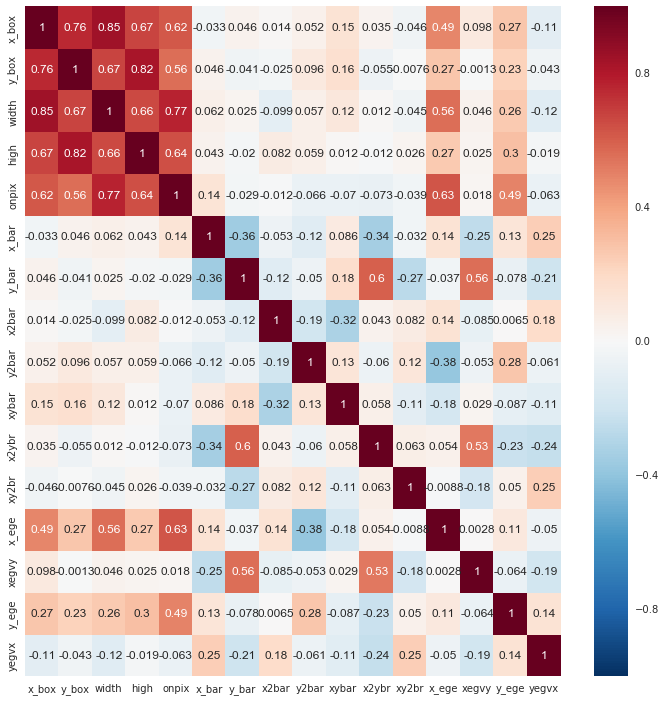

In [18]:
features_df = letter_df.drop('lettr', axis=1)
letters = letter_df['lettr']

import seaborn as sns
f_corrs = features_df.corr()

fig, ax = pylab.subplots(figsize=(12, 12))
sns.heatmap(f_corrs, annot=True, ax=ax)

The first 5 features, x_box, y_box, width, high, onpix are highly correlated with each other. 

# ANOVA Feature Selection

ANOVA F-test based feature selection requires all feature values to be positive.

In [28]:
features_df[features_df < 0].sum(axis=0)

x_box    0.0
y_box    0.0
width    0.0
high     0.0
onpix    0.0
x_bar    0.0
y_bar    0.0
x2bar    0.0
y2bar    0.0
xybar    0.0
x2ybr    0.0
xy2br    0.0
x_ege    0.0
xegvy    0.0
y_ege    0.0
yegvx    0.0
dtype: float64

The above condition holds in our case - none of the features have negative values.

In [19]:
from sklearn.feature_selection import f_classif

In [26]:
t_stats, p_vals = f_classif(features_df, letters)

f_test_results = pd.DataFrame(np.column_stack([t_stats, p_vals]),
                              index=features_df.columns.copy(),
                             columns=['test_statistic', 'p_value'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023F10715AC8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000023F10800780>], dtype=object)

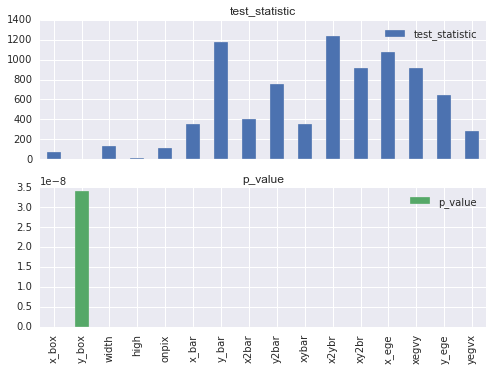

In [27]:
f_test_results.plot(kind='bar', subplots=True)

# Top 5 Features with GaussianNB Classifier

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB

In [45]:
estimator = GaussianNB()
selector = SelectKBest(f_classif, k=5)

pipeline = Pipeline([
    ('selector', selector),
    ('model', estimator)
])

cross_validator = StratifiedKFold(n_splits=10, shuffle=True)

scores = cross_val_score(pipeline, features_df, letters, 
                         cv=cross_validator, scoring='f1_macro')

score_1 = pd.Series(scores)

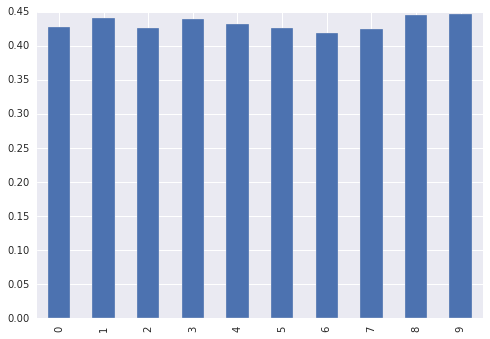

In [46]:
score_1.plot(kind='bar')

# Top 10 Features with GaussianNB Classifier

In [47]:
estimator = GaussianNB()
selector = SelectKBest(f_classif, k=10)

pipeline = Pipeline([
    ('selector', selector),
    ('model', estimator)
])

cross_validator = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(pipeline, features_df, letters, 
                         cv=cross_validator, scoring='f1_macro')

score_2 = pd.Series(scores)

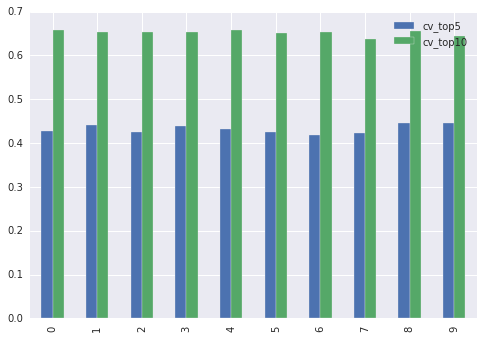

In [48]:
combined_scores = pd.concat([score_1, score_2], axis=1, keys=['cv_top5', 'cv_top10'])
combined_scores.plot(kind='bar')

# Top 15 Features with GaussianNB Classifier

In [49]:
estimator = GaussianNB()
selector = SelectKBest(f_classif, k=15)

pipeline = Pipeline([
    ('selector', selector),
    ('model', estimator)
])

cross_validator = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(pipeline, features_df, letters, 
                         cv=cross_validator, scoring='f1_macro')

score_3 = pd.Series(scores)

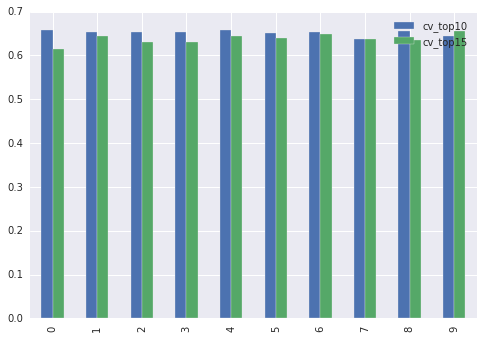

In [50]:
combined_scores2 = pd.concat([score_2, score_3], axis=1, keys=['cv_top10', 'cv_top15'])
combined_scores2.plot(kind='bar')

We get a significant (in layman terms, not in a statistical testing sense) boost in accuracy by going from top 5 to top 10 features. But the improvement in accuracy with top 15 features over top 10 features are marginal.

# Pairplot

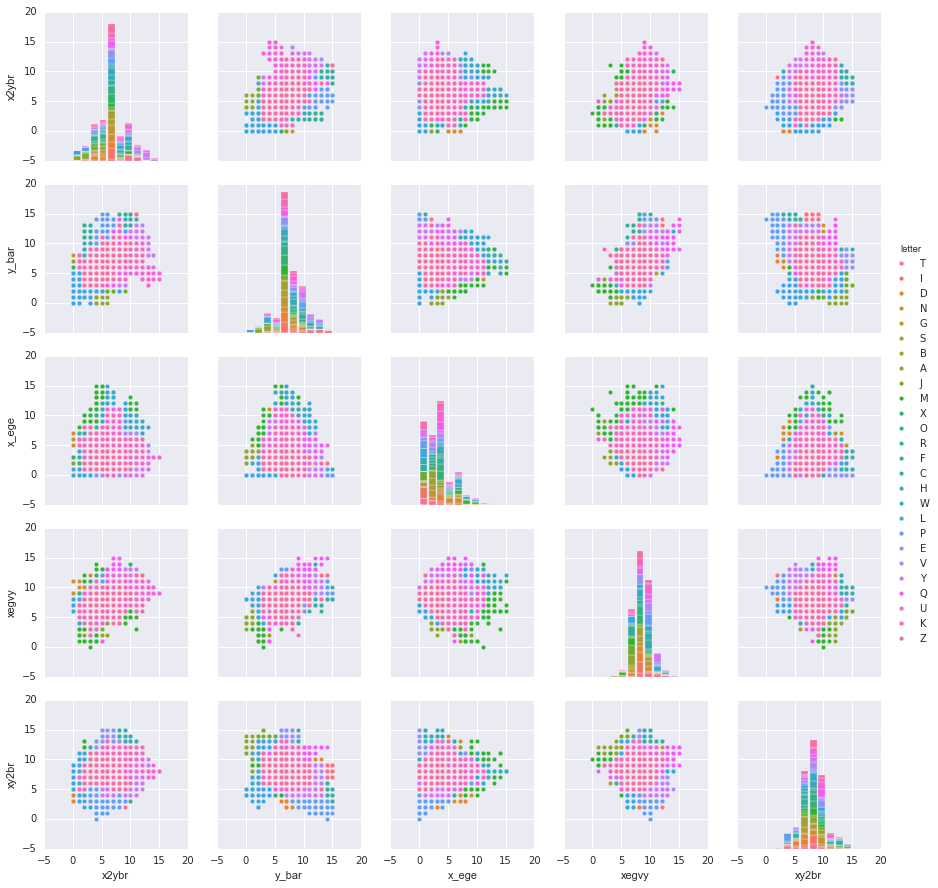

In [54]:
top_5_feature_names = f_test_results.nlargest(5, columns='test_statistic').index
pairplot_df = features_df.loc[:, top_5_feature_names].copy()
pairplot_df['letter'] = letters

sns.pairplot(pairplot_df, hue='letter')

In [58]:
from sklearn.svm import SVC

In [59]:
estimator = SVC(C=100.0, kernel='rbf')
selector = SelectKBest(f_classif, k=5)

pipeline = Pipeline([
    ('selector', selector),
    ('model', estimator)
])

cross_validator = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(pipeline, features_df, letters, 
                         cv=cross_validator, scoring='f1_macro')

svm_5 = pd.Series(scores)

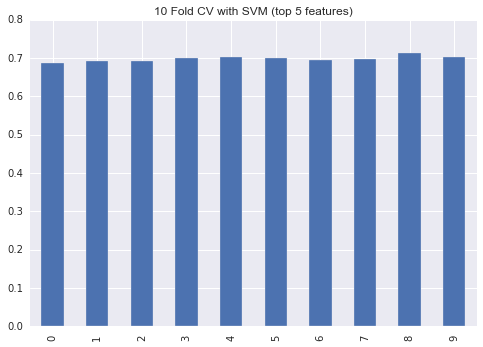

In [60]:
svm_5.plot(kind='bar', title='10 Fold CV with SVM (top 5 features)')

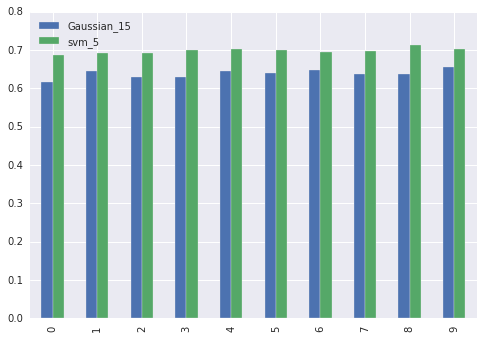

In [62]:
combined_3 = pd.concat([score_3, svm_5], axis=1, keys=['Gaussian_15', 'svm_5'])
combined_3.plot(kind='bar')

In [68]:
estimator = SVC(C=100.0, kernel='rbf')
selector = SelectKBest(f_classif, k=10)

pipeline = Pipeline([
    ('selector', selector),
    ('model', estimator)
])

cross_validator = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(pipeline, features_df, letters, 
                         cv=cross_validator, scoring='f1_macro')

svm_10 = pd.Series(scores)

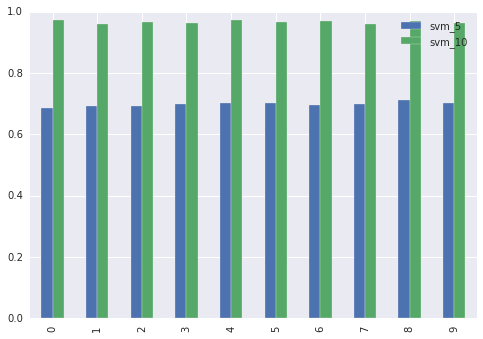

In [72]:
combined_4 = pd.concat([svm_5, svm_10], axis=1, keys=['svm_5', 'svm_10'])
combined_4.plot(kind='bar')

In [70]:
estimator = SVC(C=100.0, kernel='rbf')
selector = SelectKBest(f_classif, k=15)

pipeline = Pipeline([
    ('selector', selector),
    ('model', estimator)
])

cross_validator = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(pipeline, features_df, letters, 
                         cv=cross_validator, scoring='f1_macro')

svm_15 = pd.Series(scores)

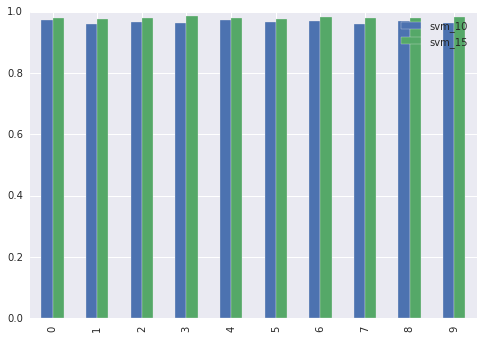

In [71]:
combined_5 = pd.concat([svm_10, svm_15], axis=1, keys=['svm_10', 'svm_15'])
combined_5.plot(kind='bar')